In [1]:
import matplotlib.pyplot as plt
import cfe.regression as rgsn
import numpy as np
import matplotlib.cm
from scipy.stats import gaussian_kde as kde
from cfe.df_utils import use_indices

Missing dependencies for OracleDemands.


In [7]:
def annotate_quantiles(labelY,ax,xbar,x99):
    xtext = -1
    ytext_offset = 0.05 #to center line orgin with text
    ytext = labelY - ytext_offset
    ytext_sign = np.sign(labelY) if np.sign(labelY) else -1
    ytext_spacing = 0.13
    
    def point_on_circle(theta,r):
        temp = r*np.cos(theta),r*np.sin(theta)
        return temp

    def intersection_on_circle(quantile,y):
        radius = np.log(xbar.quantile(quantile))/np.log(x99)
        unit_y = ytext_sign*np.pi/2 if np.abs(y/radius) >= 1 else np.arcsin(y/radius)+np.pi
        temp = point_on_circle(unit_y,radius)
        return temp
    
    ax.annotate("99%",
                xy=intersection_on_circle(0.99,labelY),
                xytext=(xtext, np.sign(ytext)*np.min([np.abs(ytext),np.log(xbar.quantile(0.99))/np.log(x99)])),
                arrowprops=dict(arrowstyle="-"))
    ax.annotate("Median",
                xy=intersection_on_circle(0.5,labelY:=labelY-ytext_sign*ytext_spacing),
                xytext=(xtext, ytext:=np.sign(ytext)*np.min([np.abs(ytext-ytext_sign*ytext_spacing), np.log(xbar.quantile(0.5))/np.log(x99)])),
                arrowprops=dict(arrowstyle="-"))
    ax.annotate("1%",
                xy=intersection_on_circle(0.01,labelY:=labelY-ytext_sign*ytext_spacing),
                xytext=(xtext, ytext:=np.sign(ytext)*np.min([np.abs(ytext-ytext_sign*ytext_spacing), np.log(xbar.quantile(0.1))/np.log(x99)])),
                arrowprops=dict(arrowstyle="-"))
    return ax

In [14]:
def make_engel_pie(r: rgsn.Regression, labelY = 0) -> plt.Axes:
    def circle(r):
        angles = np.linspace(0,2*np.pi,100)
        return r*np.cos(angles),r*np.sin(angles)

    xbar = r.predicted_expenditures().groupby(['i','t','m']).sum()
    x99 = xbar.quantile(1)
    Y = np.geomspace(1,x99,100)    
    p = ((r.y.unstack('j')>0) + 0.).mean()
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    #ax.set_position([0.1, 0.1, 0.6, 0.6])  # [left, bottom, width, height]
    
    shares = r.expenditures(Y[-1])*p
    shares = shares/shares.sum()
    
    print("Initial labels from use_indices:")
    print(use_indices(shares, ['j']))    
   
    labels = use_indices(shares,['j'])
    
    print("\nLabels and shares side-by-side before filtering:")
    for l, s in zip(labels, shares):
        print(f"Label: {l}, Share: {s}")
        
    labels['shares'] = shares
    labels = labels.j.where(labels.shares>0.01,'').tolist()
    
    print("\nLabels and shares side-by-side after filtering:")
    for l, s in zip(labels, shares):
        print(f"Label: {l}, Share: {s}")
        
    # Plot pie without labels to get positions
    wedges, texts = ax.pie(shares, rotatelabels=False, labeldistance=1.1)
    
    # Adjust the font size based on shares
    base_font_size = 14  # font size for the largest share
    min_font_size = 7    # minimum font size
    scale_factor = 0.4   # controls speed of font size reduction, adjust as needed
    
    for i, (w, l, s) in enumerate(zip(wedges, labels, shares)):
        size = base_font_size * (s/shares.max())**scale_factor
        size = max(min_font_size, size)  # Ensure it's at least the minimum size
        x, y = w.center
        angle = (w.theta2 + w.theta1) / 2.
        x = x + 1.1 * w.r * np.cos(np.deg2rad(angle))
        y = y + 1.1 * w.r * np.sin(np.deg2rad(angle))
        ax.text(x, y, l, ha='center', va='center', fontsize=size)
    
    for i in range(len(Y)-1,0,-1):
        ax.pie(r.expenditures(Y[i])*p, radius=np.log(Y[i])/np.log(x99), labeldistance = 1.4)
        
    ax.arrow(0,0,1,0,shape='full',head_width=.05,length_includes_head=True)
    ax.annotate(r"$\log x$", xy=(1, 0), color='red')  # Adjusted the xy position
   
    ax.plot(*circle(np.log(xbar.quantile(0.01))/np.log(x99)),'k')
    ax.plot(*circle(np.log(xbar.quantile(0.5))/np.log(x99)),'k')
    ax.plot(*circle(np.log(xbar.quantile(0.99))/np.log(x99)),'k')
    
    ax = annotate_quantiles(labelY,ax,xbar,x99)
    return ax

Initial labels from use_indices:
                               j
j                               
Beans                      Beans
Beef                        Beef
Beer                        Beer
Bottled Drinks    Bottled Drinks
Buns                        Buns
Butter, etc.        Butter, etc.
Cabbages                Cabbages
Cassava (flour)  Cassava (flour)
Chicken                  Chicken
Cigarettes            Cigarettes
Coffee                    Coffee
Cooking Oil          Cooking Oil
Dodo                        Dodo
Eggs                        Eggs
Fish (dried)        Fish (dried)
Fish (fresh)        Fish (fresh)
Goat                        Goat
Irish Potatoes    Irish Potatoes
Maize                      Maize
Mangos                    Mangos
Matoke                    Matoke
Millet                    Millet
Onions                    Onions
Oranges                  Oranges
Other Alcohol      Other Alcohol
Other Fruit          Other Fruit
Other Juice          Other Juice
Other Veg.

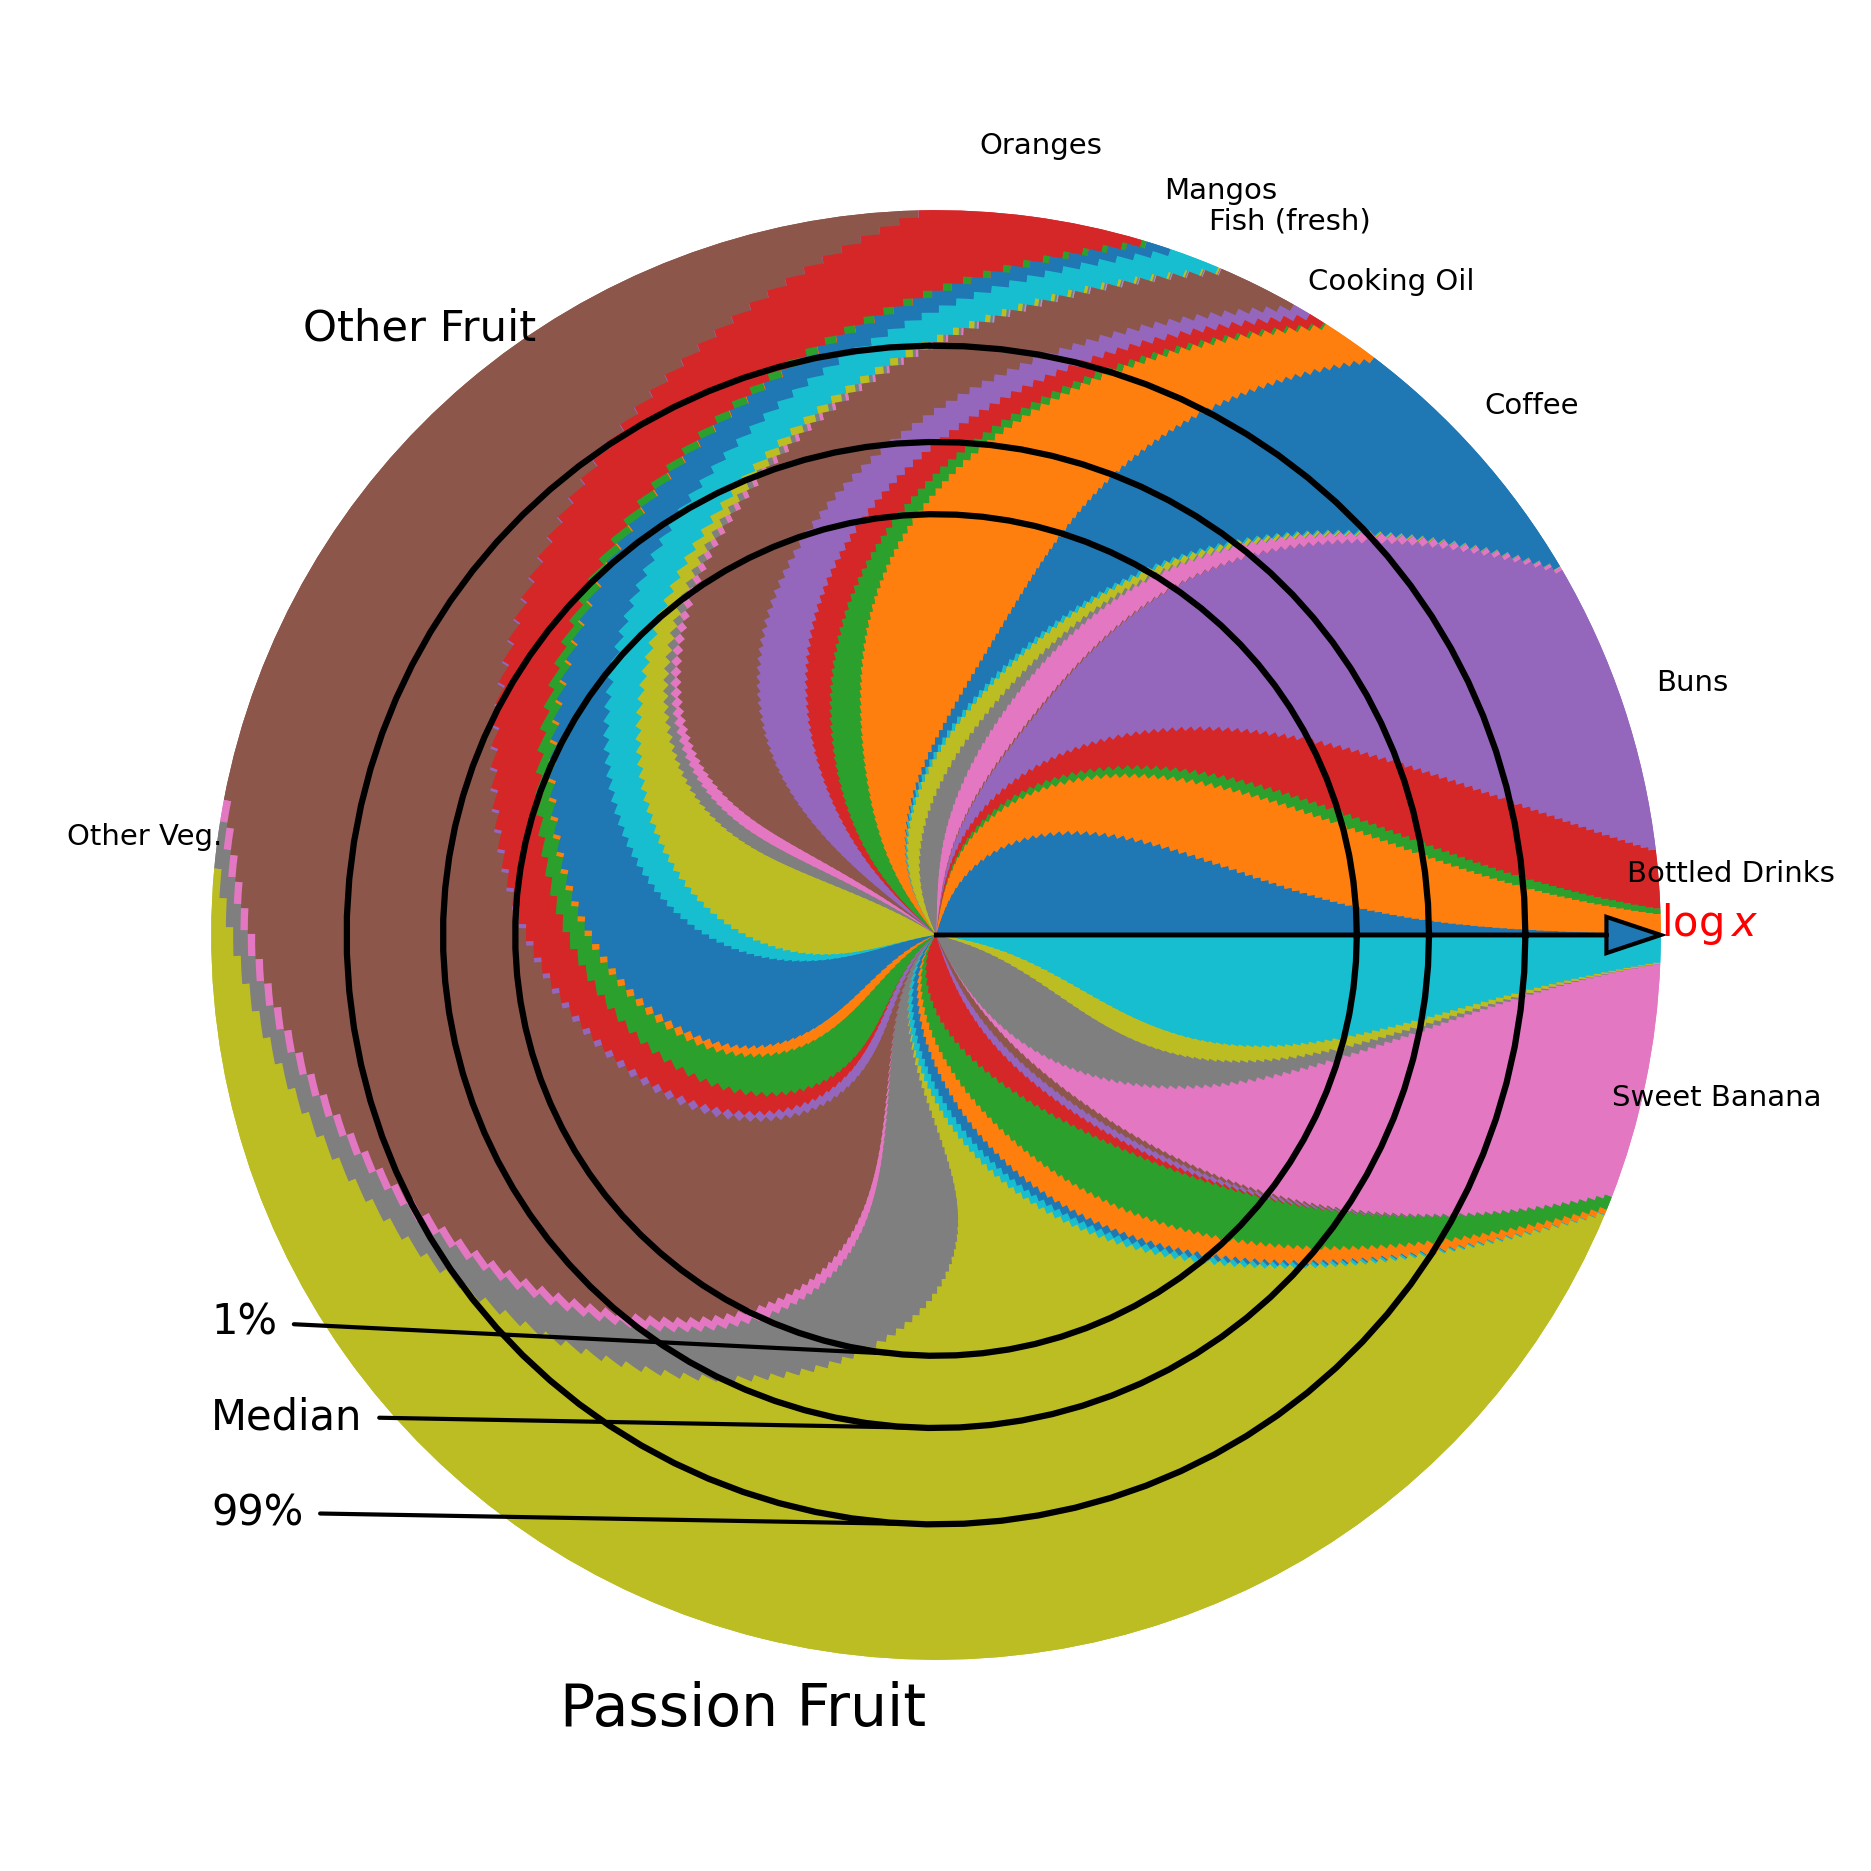

In [15]:
r = rgsn.read_pickle('./data/preferred.rgsn')
ax = make_engel_pie(r,-1)